<a href="https://colab.research.google.com/github/Kennedy87670/NLP/blob/main/Introduction_to_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# introduction to NLP Fundamentals in Tensorflow

NLP has the goal of deriving information out of natural language (could be sequences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

# Check our GPU

In [2]:
!nvidia-smi - l

Invalid combination of input arguments. Please run 'nvidia-smi -h' for help.



In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

#import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-08-27 13:43:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-27 13:43:32 (99.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we are going to be using is Kaggle's introduction to NLP dataset (text samples of tweets labeled as diaster or not diaster).

See the original source here https://www.kaggle.com/competitions/nlp-getting-started

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

#unzip data
unzip_data('nlp_getting_started.zip')

--2022-08-27 13:43:35--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.15.80, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2022-08-27 13:43:35 (161 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



# Visualize a text dataset


In [5]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df =pd.read_csv('test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# what does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
#how many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# how many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# lets visualize some random samples
import random
random_index = random.randint(0, len(train_df)-5) #create random indexes
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target:{target}", '(real diaster)' if target >0 else '(not real diaster' )
  print(f'Text:\n{text}\n')
  print('---\n')

Target:0 (not real diaster
Text:
11000 SEEDS 30 VEGETABLE FRUIT VARIETY GARDEN KIT EMERGENCY SURVIVAL GEAR MRE  - Full reaÛ_ http://t.co/DchfPXgY2m http://t.co/UgHpTzjuLK

---

Target:0 (not real diaster
Text:
[News Update] | Enugu Government to demolish illegal structures at International Conference Centre http://t.co/xcGzc45gys |Via Daily Post

---

Target:0 (not real diaster
Text:
@ElianaRaquel Like GG was BAD in the end... But at least I cared a little when GG was Dan. Cause it was a twister. I don't know Wilden IDC

---

Target:0 (not real diaster
Text:
Love how I don't get in any trouble for having people over and the house still being trashed

---

Target:1 (real diaster)
Text:
#News FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps (say what?): åÊFedEx no... http://t.co/K0Y7xFxmXA #TCOT

---



In [11]:
## split data into training and validation dataset
from sklearn.model_selection import train_test_split

In [12]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42)

In [13]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)


(6851, 6851, 762, 762)

In [14]:
# check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers
 
when dealing with text problem, one of the first things you will have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenziation - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vecto for each token (the size of the feature vetor can be defined and this embedding can be learned)

## Text Vectorization (tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None


In [17]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# setup text vectorization variable
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length= 15  # max length our sequences will be (e.g how many words from a tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [19]:
# fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)


In [20]:
# create a sample sentence and tokenize it
sample_sentence = "Theres a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# choose a random sentence from the training datset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"original text: \n {random_sentence}\
\n\nVectorized version: ")
text_vectorizer([random_sentence])

original text: 
 VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the Mediterranean after a boat carryi...

Vectorized version: 


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 72,  67, 728,  27, 713,  20, 190, 341,  22, 669,  10, 482,   6,
        330,   4]])>

In [22]:
# get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()  #get all the unique words in our training data 
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"NMumber of words in vocab: {len(words_in_vocab)}")
print(f" 5 most common words:{top_5_words} ")
print(f" 5 most common words:{bottom_5_words} ")

NMumber of words in vocab: 10000
 5 most common words:['', '[UNK]', 'the', 'a', 'in'] 
 5 most common words:['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'] 


## Creatign an Embedding using Embedding layer

To make our embedding, we are going to use Tensorflow's embedding layers: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* Input dim = the size of our get_vocabulary
* output dim = the size of the output embedding vector, for example, a value of 100 would mean token get represented by a vector 100 long
* input_length = length of sequences passed to the embedding layers

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             embeddings_initializer='uniform',
                             output_dim=128,
                             input_length= max_length #how long each input
                             )
embedding

In [24]:
# Get a random sentence from the training set
random_sentence =random.choice(train_sentences)
print(f"Original text:\n {random_sentence} ")

# embedd the random sentence (turn it into dense vectors of fixed size)
sample_embed= embedding(text_vectorizer([random_sentence]))

sample_embed

Original text:
 RT_America: RT RT_com: Eye of Super Typhoon Soudelor seen from space (TIME-LAPSE) https://t.co/FC3BxRtHPG http://t.co/BIU4koWGlz 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.0093738 ,  0.04685244,  0.02303115, ..., -0.0338943 ,
          0.01707696, -0.02525036],
        [-0.0244664 , -0.04776373, -0.03401829, ..., -0.04353389,
          0.04655417,  0.02306518],
        [ 0.03213883, -0.04468453,  0.00371194, ...,  0.04749794,
          0.04721469, -0.01067401],
        ...,
        [ 0.0343138 , -0.01909039,  0.00916097, ..., -0.04103869,
          0.03188491,  0.01870036],
        [ 0.0343138 , -0.01909039,  0.00916097, ..., -0.04103869,
          0.03188491,  0.01870036],
        [ 0.04355072, -0.02628074,  0.01169726, ...,  0.04005006,
          0.02615479,  0.02061501]]], dtype=float32)>

In [25]:
# Check out a single token embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.0093738 ,  0.04685244,  0.02303115, -0.0454494 , -0.04047151,
         0.04658215, -0.04483671, -0.04879444,  0.00044649, -0.02292571,
         0.02354311, -0.02370101,  0.03840098,  0.03008849, -0.04529747,
        -0.02728134,  0.00836222,  0.00341833,  0.02020079,  0.03133097,
         0.02885037, -0.04723947,  0.00590675,  0.02731771, -0.01629259,
        -0.01081091,  0.03855611, -0.01169504,  0.01244644, -0.04278345,
         0.04728398,  0.04438994, -0.02828889, -0.00698167, -0.03969568,
        -0.02730284, -0.01626893, -0.00432035, -0.01338748,  0.04075557,
         0.03180623, -0.00038608,  0.00516325,  0.03032732,  0.03583289,
         0.02232342,  0.00507339,  0.04210556,  0.00046026, -0.03228178,
         0.04912427, -0.04579885,  0.04520125,  0.0129136 ,  0.031685  ,
        -0.04449226, -0.00756141,  0.04132012, -0.00455024, -0.03971548,
        -0.00234127,  0.02207992,  0.04005894, -0.00135245,  0.01064097,
  

# Modelling a text dataset (running a series of experiments)

Now we have got a way tot turn our text sequences into numbers, its time to start buildinjg a series of modelling experiments.

We will start witha  baseline and move on from there.

* Model 0: naive bayes (baseline), this is from sklearn ML map
* Model 1: Feed-forward neaural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* model 5: 1D convolutional Neautral network (CNN)
* model 6: Tensorflow hub Pretrained Feature Extractor (using transfer learning for NLP)
* mODEL 7: SAME AS MODEL 6 WITH 10% OF TRAINING DAta

how are we going to approach all these?

use the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Fit a model
* Evaluate our modelm

## model 0 : getting a baseline

As with all machine learning modelling experiments, its important to create a baseline model so you have got a benchmark for future experiments to build upon.
To create a baseline, we will use sklearn multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers

🔯 Note: its common pratice to use non DL algorithms as baseline of their speed and then later using DL to see if you can improve upon them.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a tokenization and modelling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()),  #convert words to numbers using tfid
                    ('clf', MultinomialNB()) # model the text
    
])

# fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

our baseline model achieves an accuracy of: 79.27%


In [28]:
# make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

Creating an evaluation function for our model experiments
We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:

* Accuracy
* Precision
* Recall
* F1-score

🔑 Note: Since we're dealing with a classification problem, the above metrics are the most appropriate. If we were working with a regression problem, other metrics such as MAE (mean absolute error) would be a better choice.

In [29]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [30]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1: A simple dense model
The first "deep" model we're going to build is a single layer dense model. In fact, it's barely going to have a single layer.

It'll take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.

If the previous sentence sounds like a mouthful, it'll make sense when we code it out (remember, if in doubt, code it out).

And since we're going to be building a number of TensorFlow deep learning models, we'll import our create_tensorboard_callback() function from helper_functions.py to keep track of the results of each.

In [31]:
# Create a tensorboard call back (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# create a directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

In [32]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model


In [33]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [34]:
# Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
# Fit the model
model_1_history = model_1.fit(x= train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              y= train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20220827-134340
Epoch 1/5
215/215 [==============================] - 5s 5ms/step - loss: 0.6107 - accuracy: 0.6904 - val_loss: 0.5344 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4413 - accuracy: 0.8173 - val_loss: 0.4713 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3472 - accuracy: 0.8593 - val_loss: 0.4571 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2846 - accuracy: 0.8902 - val_loss: 0.4671 - val_accuracy: 0.7940
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2379 - accuracy: 0.9091 - val_loss: 0.4785 - val_accuracy: 0.7887


In [36]:
# check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4785 - accuracy: 0.7887


[0.4784773886203766, 0.7887139320373535]

In [37]:
# maqke some predictions and evaluate those
model_1_pred_probs= model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [38]:
# look at a single preiction
model_1_pred_probs[0]

array([0.3930545], dtype=float32)

In [39]:
# look at thr first 10 preiction
model_1_pred_probs[:10]

array([[0.3930545 ],
       [0.73246104],
       [0.99747014],
       [0.10493158],
       [0.10368444],
       [0.9492566 ],
       [0.902009  ],
       [0.99308515],
       [0.9660247 ],
       [0.26166233]], dtype=float32)

In [40]:
# convert model predictions probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [41]:
#calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.793474487062673,
 'recall': 0.7887139107611548,
 'f1': 0.7858143716287432}

In [42]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [43]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualize Embedding

In [44]:
# Get the vocabulary from the text vectorization layers
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
# model_1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [46]:
# Get the weight matrix of embedding layer 
#(these are the numerical patterns between the text in the training dataset the model has learned)
# embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
# print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)


Now we've got the embedding matrix model has learned to represnt our tokens, lets see how we can visualize it.

To do so. Tensorflow has a handy tool called projector:
https://www.tensorflow.org/text/guide/word_embeddings

In [47]:
# create embedding files (we got this from tensorflow's word embedding documentation)
# import io
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embed_weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()


In [48]:
# Download files from colab to upload to projector
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Recurrent Neural Network (RNN'S)
RNN's are useful for sequence data

The premise of a recurrent neural network is to use the represntation of a later night

## Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)
Our structure of an RNN typically looks like this:

inputs(text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)

In [49]:
# Create an LSTM mOdel
from tensorflow.keras import layers


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")


(None, 15, 128)
(None, 64)


In [50]:
# get a summary()
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [51]:

# compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [52]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])


Saving TensorBoard log files to: model_logs/LSTM/20220827-134353
Epoch 1/5
215/215 [==============================] - 6s 8ms/step - loss: 0.2277 - accuracy: 0.9188 - val_loss: 0.5628 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1555 - accuracy: 0.9413 - val_loss: 0.6216 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1306 - accuracy: 0.9508 - val_loss: 0.6900 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1060 - accuracy: 0.9591 - val_loss: 0.7048 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0858 - accuracy: 0.9672 - val_loss: 1.0352 - val_accuracy: 0.7756


In [53]:
# make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[1.0193965e-03],
       [6.9394475e-01],
       [9.9944872e-01],
       [6.7841141e-03],
       [2.6783140e-04],
       [9.9672937e-01],
       [6.0716015e-01],
       [9.9970132e-01],
       [9.9937207e-01],
       [3.5949060e-01]], dtype=float32)

In [54]:

# convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [55]:

val_labels

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,

In [56]:
# calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results


{'accuracy': 77.55905511811024,
 'precision': 0.7841484675632434,
 'recall': 0.7755905511811023,
 'f1': 0.770997050538307}

## Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features  to an LSTM cell but has less parameters

In [57]:
from IPython.core.inputtransformer2 import leading_empty_lines
# build an RNN using GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need return sequence true
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)
# x = layers.GRU(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [58]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 

In [59]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [60]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20220827-134405
Epoch 1/5
215/215 [==============================] - 4s 8ms/step - loss: 0.1713 - accuracy: 0.9437 - val_loss: 0.6928 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1012 - accuracy: 0.9635 - val_loss: 0.7725 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0858 - accuracy: 0.9691 - val_loss: 0.7811 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0747 - accuracy: 0.9711 - val_loss: 0.9921 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0640 - accuracy: 0.9727 - val_loss: 1.0611 - val_accuracy: 0.7690


In [61]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[2.9248450e-02],
        [8.4906262e-01],
        [9.9997854e-01],
        [4.9245272e-02],
        [3.8268682e-04],
        [9.9965250e-01],
        [9.6828640e-01],
        [9.9999738e-01],
        [9.9999166e-01],
        [5.5601871e-01]], dtype=float32))

In [62]:

# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[2.9248450e-02],
        [8.4906262e-01],
        [9.9997854e-01],
        [4.9245272e-02],
        [3.8268682e-04],
        [9.9965250e-01],
        [9.6828640e-01],
        [9.9999738e-01],
        [9.9999166e-01],
        [5.5601871e-01]], dtype=float32))

In [63]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [64]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.9028871391076,
 'precision': 0.7720661775336959,
 'recall': 0.7690288713910761,
 'f1': 0.7662397121174332}

## Model_4 : bidirectional RNN

nORMALRNN'S GO FROM LEFT TO RIGHT (JUST LIKE YOU READ AN ENGLISH sentence) however, a bidirectional RNN goes from right to left as well as left to right.


In [65]:
# build a bidirection RNN in Tensorflow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True)) (x)
#print(x.shape)
x = layers.Bidirectional(layers.LSTM(64)) (x)
outputs= layers.Dense(1, activation="sigmoid") (x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [66]:
# get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [67]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [68]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])


Saving TensorBoard log files to: model_logs/bidirectional_RNN/20220827-134419
Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.1070 - accuracy: 0.9653 - val_loss: 1.0565 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0546 - accuracy: 0.9768 - val_loss: 1.0842 - val_accuracy: 0.7612
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0489 - accuracy: 0.9783 - val_loss: 1.3156 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0455 - accuracy: 0.9791 - val_loss: 1.3172 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0435 - accuracy: 0.9788 - val_loss: 0.9772 - val_accuracy: 0.7730


In [69]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[1.0627155e-01],
       [8.0230856e-01],
       [9.9986899e-01],
       [1.9399637e-01],
       [1.4059013e-04],
       [9.8859954e-01],
       [3.9428332e-01],
       [9.9995100e-01],
       [9.9988151e-01],
       [3.2359049e-01]], dtype=float32)

In [70]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [71]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.29658792650919,
 'precision': 0.7763206990944375,
 'recall': 0.7729658792650919,
 'f1': 0.7701512125975899}

### Convolutional Neaural networks for text (and other types of sequences)

We've used CNNs for images but images are typically 2d (height x width)... however, our text data is 1D.

Previously we've Conv2D for our images but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

Inputs (text) -> Tokenization -> Embedding -> Layers(s) (typically Conv1D + pooling) -> Outputs (class probabilities)

# model_5 Conv1D

In [72]:
# testing out our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into ebedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # ngram of 5, reads 5 words at atime
                        activation="relu",
                        padding="valid") # default = "valid" the output is smaller
conv_1d_output = conv_1d(embedding_test) #pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to get the4 most feature or get the feature with the higest

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [73]:
# create 1-dimentional convolutional layer to model sequences
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [74]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])


Saving TensorBoard log files to: model_logs/Conv1D/20220827-134439
Epoch 1/5
215/215 [==============================] - 4s 6ms/step - loss: 0.1266 - accuracy: 0.9587 - val_loss: 0.8924 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0744 - accuracy: 0.9734 - val_loss: 1.0425 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0602 - accuracy: 0.9774 - val_loss: 1.0926 - val_accuracy: 0.7520
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0549 - accuracy: 0.9784 - val_loss: 1.1236 - val_accuracy: 0.7493
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0510 - accuracy: 0.9784 - val_loss: 1.1934 - val_accuracy: 0.7598


In [75]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[4.6609503e-01],
       [9.0702724e-01],
       [9.9996018e-01],
       [4.8147544e-02],
       [1.8643375e-07],
       [9.9681062e-01],
       [9.5637631e-01],
       [9.9999154e-01],
       [9.9999988e-01],
       [7.8597629e-01]], dtype=float32)

In [76]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [77]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.98425196850394,
 'precision': 0.7595269214829928,
 'recall': 0.7598425196850394,
 'f1': 0.7589841599505696}

## Model 6: Tensorflow hub pretarined sentence encoder Transfer learning

In [78]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([ sample_sentence,
    "When you can the universal sentence encoder on a sentence,it",])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [79]:
# Create a keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [80]:
# Create model using Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    #layers.Dense(128, activation='relu'),
    #layers.Dense(64, activation='relu'),
    layers.Dense(1, activation="sigmoid")
], name= "model_6_USE")


# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()



Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [81]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])


Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220827-134506
Epoch 1/5
215/215 [==============================] - 5s 13ms/step - loss: 0.6478 - accuracy: 0.7425 - val_loss: 0.6118 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 12ms/step - loss: 0.5805 - accuracy: 0.7923 - val_loss: 0.5622 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.5376 - accuracy: 0.7989 - val_loss: 0.5311 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.5088 - accuracy: 0.7999 - val_loss: 0.5096 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4887 - accuracy: 0.8008 - val_loss: 0.4951 - val_accuracy: 0.7848


In [82]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.36786345],
       [0.6779815 ],
       [0.8611336 ],
       [0.33881718],
       [0.6535352 ],
       [0.730934  ],
       [0.8273482 ],
       [0.83963805],
       [0.7399542 ],
       [0.20156804]], dtype=float32)

In [83]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [84]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 78.4776902887139,
 'precision': 0.7849494067766415,
 'recall': 0.7847769028871391,
 'f1': 0.7837862430999359}

## Model 7: TF Hub pretrained USE but with 10% of training data

Tranfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, lets replicate "model 6" except we will train it on 10% of the data

In [85]:
## Note: making data splits like below leads to data leakage (model_7 trained )
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# Create subsets of 10% of the data
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In my opinion we should get the data from history and then make the split at the beginning before moving forward

In [86]:
# making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent= train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [87]:
# check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [88]:
# check the number of targets in our subset data
train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [89]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To create a model the same as a previous model i ahve created we can use tf.keras.modelclone
https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [90]:
#lets build a model the same as model_6
model_7 =tf.keras.models.clone_model(model_6)



# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()



Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [91]:
# Train a classifier on top of pretrained embeddings
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder_10_percent_correct")])


Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct/20220827-134525
Epoch 1/5
22/22 [==============================] - 3s 40ms/step - loss: 0.6855 - accuracy: 0.5810 - val_loss: 0.6813 - val_accuracy: 0.6325
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.6728 - accuracy: 0.7080 - val_loss: 0.6724 - val_accuracy: 0.7073
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.6613 - accuracy: 0.7401 - val_loss: 0.6639 - val_accuracy: 0.7244
Epoch 4/5
22/22 [==============================] - 0s 21ms/step - loss: 0.6503 - accuracy: 0.7810 - val_loss: 0.6557 - val_accuracy: 0.7441
Epoch 5/5
22/22 [==============================] - 0s 21ms/step - loss: 0.6399 - accuracy: 0.7898 - val_loss: 0.6480 - val_accuracy: 0.7598


In [92]:

# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.46820423],
       [0.5094784 ],
       [0.56162274],
       [0.44650105],
       [0.4968901 ],
       [0.54703194],
       [0.5385849 ],
       [0.5284952 ],
       [0.5409618 ],
       [0.4406309 ]], dtype=float32)

In [93]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [94]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 75.98425196850394,
 'precision': 0.7736374424344706,
 'recall': 0.7598425196850394,
 'f1': 0.7527539079081671}

## comparing


In [95]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.871391,0.793474,0.788714,0.785814
lstm,77.559055,0.784148,0.775591,0.770997
gru,76.902887,0.772066,0.769029,0.766240
bidirectional,77.296588,0.776321,0.772966,0.770151
conv1d,75.984252,0.759527,0.759843,0.758984
tf_hub_sentence_encoder,78.477690,0.784949,0.784777,0.783786
tf_hub_10_percent_data,75.984252,0.773637,0.759843,0.752754


In [96]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

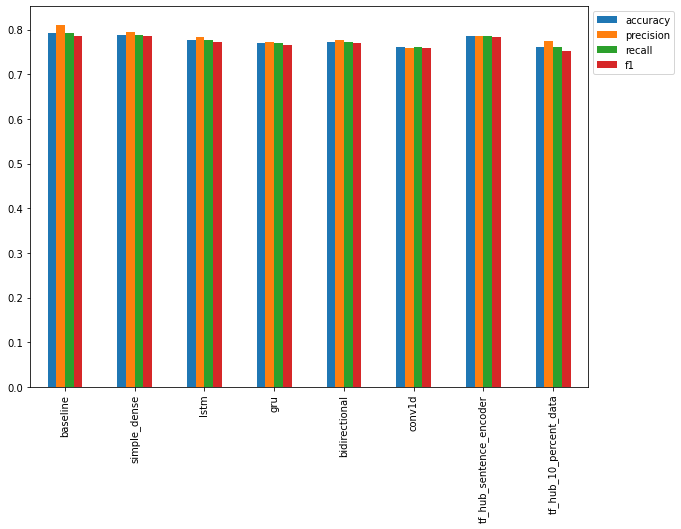

In [97]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


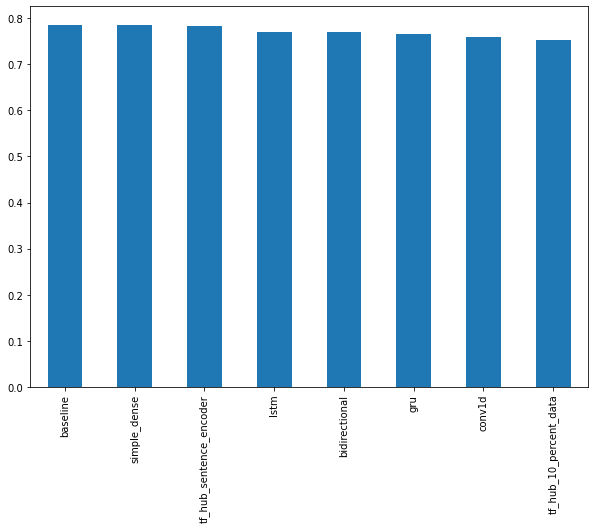

In [98]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));


In [99]:
# upload our model training to tensorboard.dev

## Saving and loading a trained model

There are two main formats to save a model to in Tensorflow:
1. The HDF5 format
2. The "saveModel" format (this is the default when using Tensorflow)

In [100]:
# Save TF hub sentence Encoder model to HDF5
model_6.save("model_6.h5")

In [101]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})


In [102]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4951 - accuracy: 0.7848


[0.4950861930847168, 0.7847769260406494]

Now let's save to the saveModel format

In [103]:
# Save TF Hub Sentence Encoder model to SaveModel Format (default)
model_6.save("model_6_SavedModel_format")

In [104]:

# load in a model from saved model format
loaded_model_6_savedmodel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [105]:
# Evaluate model saved model format
loaded_model_6_savedmodel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4951 - accuracy: 0.7848


[0.4950861930847168, 0.7847769260406494]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of those wrong examples which ones is it getting most wrong (those will prediction probabilities closest to the opposite class)

For example if a sample should have a label of0 but our model predicts a prediction probability of 0.999 (close to one) and vice versa

In [106]:
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip 

--2022-08-27 13:45:57--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.15.80, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  65.4MB/s    in 18s     

2022-08-27 13:46:15 (51.3 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.inde

In [107]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.367863
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.677981
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.861134
3,@camilacabello97 Internally and externally scr...,1,0.0,0.338817
4,Radiation emergency #preparedness starts with ...,1,1.0,0.653535


In [108]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803664
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.758668
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.737669
181,Article by Michael Jackman at Metro Times Detr...,0,1.0,0.706581
759,FedEx will no longer transport bioterror patho...,0,1.0,0.701280
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.687865
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.677981
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.677902
117,Public Hearing on 2015-16 @SUNY_Orange budget ...,0,1.0,0.675508
80,GENERAL AUDIENCE: On Wounded Families | ZENIT ...,0,1.0,0.673347


A reminder:

* 0 = Not a real diaster Tweet
* 1 = Real diaster Tweet

In [109]:
# check the fasle positvies (model predicted 1 instead of 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"TARGET:{target}, pred: {pred}, Prob: {pred_prob} ")
  print(f"Text: \n{text}\n ")
  print("----\n")

TARGET:0, pred: 1.0, Prob: 0.8036637902259827 
Text: 
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods
 
----

TARGET:0, pred: 1.0, Prob: 0.7586683630943298 
Text: 
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying
 
----

TARGET:0, pred: 1.0, Prob: 0.7376685738563538 
Text: 
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!
 
----

TARGET:0, pred: 1.0, Prob: 0.7065812945365906 
Text: 
Article by Michael Jackman at Metro Times Detroit:
The group later downgraded the estimate to 37 square miles of... http://t.co/h31mmuduqt
 
----

TARGET:0, pred: 1.0, Prob: 0.701280415058136 
Text: 
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J
 
----

TARGET:0, pred: 1.0, Prob: 0.6878654956817627 
Text: 
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for

In [110]:
# check the fasle negatives (model predicted 0 instead of 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"TARGET:{target}, pred: {pred}, Prob: {pred_prob} ")
  print(f"Text: \n{text}\n ")
  print("----\n")

TARGET:1, pred: 0.0, Prob: 0.17977361381053925 
Text: 
@DavidVonderhaar At least you were sincere ??
 
----

TARGET:1, pred: 0.0, Prob: 0.17549921572208405 
Text: 
Indeed!! I am fully aware of that battle! I support you in that fight!!  https://t.co/MctJnZX4H8
 
----

TARGET:1, pred: 0.0, Prob: 0.17208260297775269 
Text: 
I wanna set some shit on fire.
 
----

TARGET:1, pred: 0.0, Prob: 0.16815067827701569 
Text: 
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu
 
----

TARGET:1, pred: 0.0, Prob: 0.1647024154663086 
Text: 
Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP
 
----

TARGET:1, pred: 0.0, Prob: 0.15554775297641754 
Text: 
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube
 
----

TARGET:1, pred: 0.0, Prob: 0.15479467809200287 
Text: 
@reriellechan HE WAS THE LICH K

In [111]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [115]:
# Mkaing predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences,10)
for test_samples in test_samples:
  pred_prob = tf.squeeze(loaded_model_6_savedmodel_format.predict([test_samples]))
  pred =tf.round(pred_prob)
  print(f"Pred:{int(pred)}, Prob:{pred_prob} ")
  print(f"Text:\n{test_samples}\n ")
  print("----\n")

Pred:0, Prob:0.275495320558548 
Text:
@crash_matrix @TheMercedesXXX With a minivan :3
 
----

Pred:0, Prob:0.45259302854537964 
Text:
@TarekFatah you are burning in enemity of Pakistan .i m sure you will burn more and more
 
----

Pred:0, Prob:0.31113019585609436 
Text:
Two shows I've loved this summer - Catastrophe and Unreal
 
----

Pred:1, Prob:0.7331711053848267 
Text:
411Naija åÈ Flood: Two people dead 60 houses destroyed in Kaduna http://t.co/yAvL49DoOF
 
----

Pred:0, Prob:0.47067052125930786 
Text:
Alabama home quarantined over possible EbolaåÊcase https://t.co/jr4k7IiSbu
 
----

Pred:1, Prob:0.6164430975914001 
Text:
@PamelaMueller @TIME  It is an honour  and privlege to pray. I have witnessed these bush fires when living in Australia
 
----

Pred:1, Prob:0.5882486701011658 
Text:
Admiral Says Public Schools Nationwide Shortchanging Military Kids | http://t.co/g0q0bzBjli http://t.co/rbt3mLhlX7 via @Militarydotcom
 
----

Pred:1, Prob:0.7911356687545776 
Text:
70 yrs since the 